In [22]:
pip install opencv-python

In [23]:
import numpy as np
import cv2
import os
import random

import tensorflow as tf
from tensorflow import keras
from keras import layers, models



from PIL import Image
import glob

import matplotlib.pyplot as plt


In [24]:
def load_mias_data(directory='C:/Users/ilse-/mias-mammography/mias-mammography/all-mias-roi'):
    images = []
    labels = []

    for filename in os.listdir(directory):
        if filename.endswith('.pgm'):  # Asume que las imágenes están en formato .pgm, cambia según corresponda
            img_path = os.path.join(directory, filename)
            img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
            img = cv2.resize(img, (256, 256))  # Cambia el tamaño de la imagen si es necesario

            images.append(img)

            # Aquí puedes añadir etiquetas si las tienes. Por ahora, solo añadiré 0 como etiqueta ficticia
            labels.append(0)

    return (np.array(images), np.array(labels)), (None, None)  # Retorna imágenes y etiquetas, y por ahora 'None' para el conjunto de validación

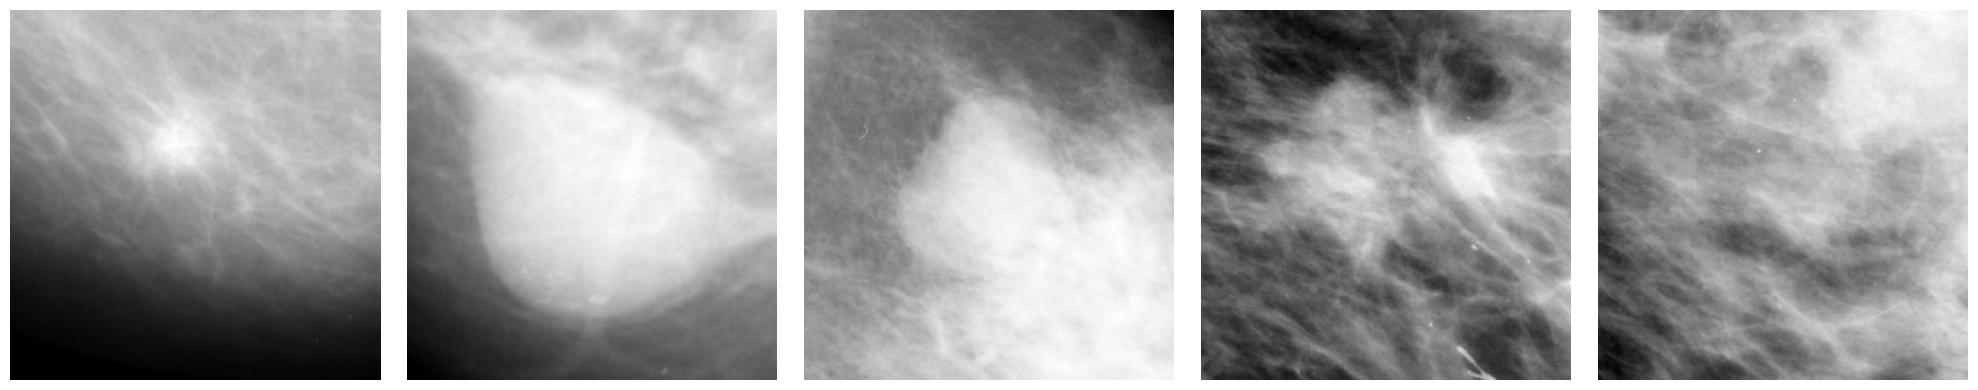

In [25]:
def visualize_random_images(images, num_images=5):
    selected_images = random.sample(list(images), num_images)
    
    plt.figure(figsize=(20, 4))
    for i, img in enumerate(selected_images):
        plt.subplot(1, num_images, i + 1)
        plt.imshow(img, cmap='gray')
        plt.axis('off')
    plt.tight_layout()
    plt.show()

# Cargar las imágenes
(x_train, _), _ = load_mias_data()

# Visualizar 10 imágenes aleatorias
visualize_random_images(x_train)

In [26]:
(x_train, _), (_, _) = load_mias_data()
x_train = x_train.astype('float32') / 255.0

In [27]:
def generator_block(filters, kernel_size, upsampling=False):
    block = models.Sequential()
    if upsampling:
        block.add(layers.UpSampling2D())
    block.add(layers.Conv2D(filters, kernel_size, padding="same"))
    block.add(layers.BatchNormalization())
    block.add(layers.LeakyReLU())
    return block

In [28]:
def discriminator_block(filters, kernel_size, downsampling=False):
    block = models.Sequential()
    block.add(layers.Conv2D(filters, kernel_size, padding="same"))
    block.add(layers.BatchNormalization())
    block.add(layers.LeakyReLU())
    if downsampling:
        block.add(layers.AveragePooling2D())
    return block

In [30]:
def expand_generator(model):
    last_conv_layer = None
    for layer in reversed(model.layers):
        if isinstance(layer, layers.Conv2D):
            last_conv_layer = layer
            break
            
    if last_conv_layer is None:
        raise ValueError("No se encontró una capa Conv2D.")
        
    filters = last_conv_layer.filters // 2
    filters = max(filters, 32)
    kernel_size = (3, 3)

    model.add(generator_block(filters, kernel_size, upsampling=True))
    model.add(layers.Conv2D(1, (1, 1), activation="sigmoid"))
    return model

def expand_discriminator(model):
    first_conv_layer = None
    for layer in model.layers:
        if isinstance(layer, layers.Conv2D):
            first_conv_layer = layer
            break
            
    if first_conv_layer is None:
        raise ValueError("No se encontró una capa Conv2D.")
        
    filters = first_conv_layer.filters * 2
    filters = min(filters, 512)
    kernel_size = (3, 3)
    
    new_model = models.Sequential()
    new_model.add(discriminator_block(filters, kernel_size, downsampling=True))
    for layer in model.layers:
        new_model.add(layer)
    return new_model

In [31]:
generator = generator_block(128, (4, 4))
generator.add(layers.Conv2D(1, (1, 1), activation="sigmoid"))

discriminator = models.Sequential()
discriminator.add(layers.Input(shape=(4, 4, 1)))
discriminator.add(discriminator_block(128, (4, 4)))
discriminator.add(layers.Flatten())
discriminator.add(layers.Dropout(0.4))
discriminator.add(layers.Dense(1, activation="sigmoid"))

In [32]:
opt = tf.keras.optimizers.Adam(lr=0.0002, beta_1=0.5)
discriminator.compile(loss="binary_crossentropy", optimizer=opt, metrics=["accuracy"])
discriminator.trainable = False
gan = models.Sequential([generator, discriminator])
gan.compile(loss="binary_crossentropy", optimizer=opt)

In [33]:
def train_gan(generator, discriminator, gan, x_train, epochs, batch_size, resolution):
    
    valid = np.ones((batch_size, 1))
    fake = np.zeros((batch_size, 1))
    
    for epoch in range(epochs):
        idx = np.random.randint(0, x_train.shape[0], batch_size)
        real_imgs = x_train[idx]
        
        noise = np.random.normal(0, 1, (batch_size, generator.input_shape[1]))
        generated_imgs = generator.predict(noise)
        
        d_loss_real = discriminator.train_on_batch(real_imgs, valid)
        d_loss_fake = discriminator.train_on_batch(generated_imgs, fake)
        d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)
        
        g_loss = gan.train_on_batch(noise, valid)
        
        print(f"{epoch}/{epochs} [D loss: {d_loss[0]} | D accuracy: {d_loss[1]}] [G loss: {g_loss}]")
        

    generator.save(f"generator_{resolution}.h5")
    discriminator.save(f"discriminator_{resolution}.h5")

In [34]:
def resize_dataset(x_train, resolution):
    resized_data = np.array([cv2.resize(img, (resolution, resolution)) for img in x_train])
    return resized_data[..., np.newaxis]

In [36]:
resolutions = [4, 8, 16, 32, 64, 128, 256]
for resolution in resolutions:
    current_dataset = resize_dataset(x_train, resolution)
    
    train_gan(generator, discriminator, gan, current_dataset, epochs=10000, batch_size=128, resolution=resolution)
    
    if resolution != resolutions[-1]:
        generator = expand_generator(generator)
        discriminator = expand_discriminator(discriminator)

AttributeError: 'Sequential' object has no attribute '_nested_inputs'

In [17]:
def generate_and_visualize_images(generator, num_images=5):
    noise = np.random.normal(0, 1, (num_images, 128))
    generated_images = generator.predict(noise)

    plt.figure(figsize=(20, 4))
    for i in range(num_images):
        plt.subplot(1, num_images, i + 1)
        plt.imshow(generated_images[i, :, :], interpolation='nearest', cmap='gray')
        plt.axis('off')
    plt.tight_layout()
    plt.show()

# Genera y visualiza 10 imágenes después de entrenar la GAN
generate_and_visualize_images(generator, num_images=10)

ValueError: in user code:

    File "c:\Users\ilse-\anaconda3\envs\bigdata\lib\site-packages\keras\src\engine\training.py", line 2440, in predict_function  *
        return step_function(self, iterator)
    File "c:\Users\ilse-\anaconda3\envs\bigdata\lib\site-packages\keras\src\engine\training.py", line 2425, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "c:\Users\ilse-\anaconda3\envs\bigdata\lib\site-packages\keras\src\engine\training.py", line 2413, in run_step  **
        outputs = model.predict_step(data)
    File "c:\Users\ilse-\anaconda3\envs\bigdata\lib\site-packages\keras\src\engine\training.py", line 2381, in predict_step
        return self(x, training=False)
    File "c:\Users\ilse-\anaconda3\envs\bigdata\lib\site-packages\keras\src\utils\traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "c:\Users\ilse-\anaconda3\envs\bigdata\lib\site-packages\keras\src\engine\input_spec.py", line 253, in assert_input_compatibility
        raise ValueError(

    ValueError: Exception encountered when calling layer 'sequential' (type Sequential).
    
    Input 0 of layer "conv2d" is incompatible with the layer: expected min_ndim=4, found ndim=2. Full shape received: (None, 128)
    
    Call arguments received by layer 'sequential' (type Sequential):
      • inputs=tf.Tensor(shape=(None, 128), dtype=float32)
      • training=False
      • mask=None
